# Use finite element method to compute committor 

The used finite element code is taken from https://github.com/mar1akc/transition_path_theory_FEM_distmesh and used to solve the committor problem of the Mueller Brown potential impelemented in 2dpotentials 

In [1]:
from IPython.core.display import  HTML
# Jupyter display settings
display(HTML("<style>.container { width:90% !important; }</style>"))

General imports 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import csv 
import torch 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


Import Mueller Brown potential 

In [3]:
from potentials.EntropicSwitchTrippleWellPotential import EntropicSwitchTrippleWellPotential
pot = EntropicSwitchTrippleWellPotential()

Import FEM methods 

In [4]:
import sys 
## In the following line the path should be changed to where the packahe from 
## https://github.com/mar1akc/transition_path_theory_FEM_distmesh is locally
sys.path.append("/home/tpigeon/Bureau/These_Inria-IFP/python_package/transition_path_theory_FEM_distmesh")
from distmesh import *
from FEM_TPT import *

Declare parameters for reactant and product definition

In [5]:
xa = pot.minR[0,0]
ya = pot.minR[0,1]
xb = pot.minP[0,0]
yb = pot.minP[0,1]
ra = pot.R_radius
rb = pot.P_radius

Generate the potential function values on a meshgrid and show on which zone of space the finite element solution will be approxiamted

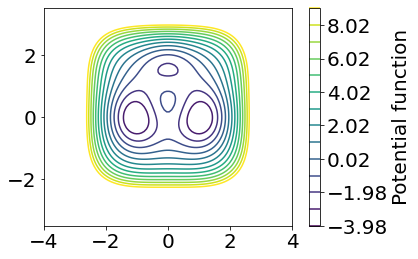

In [6]:
generate_mesh = True
h0 = 0.05 # scaling parameter
Vbdry = 10 # Maximal value considered for the potential 
beta = 4

nx,ny= (100,100)
nxy = nx*ny
xmin = -4.0
xmax = 4.0
ymin = -3.5
ymax = 3.5
x1 = np.linspace(xmin, xmax, nx)
y1 = np.linspace(ymin, ymax, ny)
x_grid, y_grid = np.meshgrid(x1,y1)
x_vec = np.reshape(x_grid, (nxy,1))
y_vec = np.reshape(y_grid, (nxy,1))
v = np.zeros(nxy)
xy = np.concatenate((x_vec,y_vec),axis=1)
v = pot.V(xy)
vmin = np.amin(v)
v_grid = np.reshape(v,(nx,ny))    
# graphics
plt.rcParams.update({'font.size': 20})
ls = plt.contour(x_grid, y_grid, v_grid, np.arange(vmin,Vbdry,1))
plt.colorbar(label="Potential function", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)

Define the boudaries of the finite element problem 

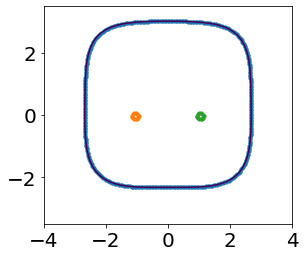

In [7]:
# set sets A and B and the outer boundary
Na = int(round(2*math.pi*ra/h0))
Nb = int(round(2*math.pi*rb/h0))
ptsA = put_pts_on_circle(xa,ya,ra,Na)
ptsB = put_pts_on_circle(xb,yb,rb,Nb)

# outer boundary
bdrydata = plt.contour(x_grid,y_grid,v_grid,[Vbdry]) # need this for the meshing
for item in bdrydata.collections:
    for i in item.get_paths():
        p_outer = i.vertices
# reparametrize the outer boundary to make the distance 
# between the nearest neighbor points along it approximately h0
pts_outer = reparametrization(p_outer,h0);

Nouter = np.size(pts_outer,axis=0)
Nfix = Na+Nb+Nouter

plt.scatter(pts_outer[:,0],pts_outer[:,1],s=10)
plt.scatter(ptsA[:,0],ptsA[:,1],s=10)
plt.scatter(ptsB[:,0],ptsB[:,1],s=10)
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})


Generate the Mesh

count =  200 displacement =  0.011611112488054244
count =  400 displacement =  0.004286806305823619
Npts =  12489  Ntri =  24588


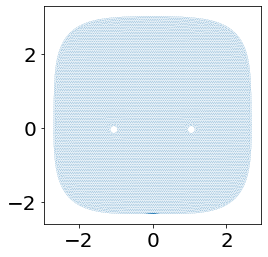

In [8]:
# input data for triangulation
# bbox = [xmin,xmax,ymin,ymax]
if generate_mesh == True:
    bbox = [xmin,xmax,ymin,ymax]
    pfix = np.zeros((Nfix,2))
    pfix[0:Na,:] = ptsA
    pfix[Na:Na+Nb,:] = ptsB
    pfix[Na+Nb:Nfix,:] = pts_outer

    def dfunc(p):
        d0 = pot.V(p)
        dA = dcircle(p,xa,ya,ra)
        dB = dcircle(p,xb,yb,rb)
        d = ddiff(d0-Vbdry,dunion(dA,dB))
        return d

    pts,tri = distmesh2D(dfunc,huniform,h0,bbox,pfix)
    with open('ES_pts.csv', 'w', newline='') as file:
        mywriter = csv.writer(file, delimiter=',')
        mywriter.writerows(pts)

    with open('ES_tri.csv', 'w', newline='') as file:
        mywriter = csv.writer(file, delimiter=',')
        mywriter.writerows(tri)
else:
    pts = np.loadtxt('ES_pts.csv', delimiter=',', dtype=float)
    tri = np.loadtxt('ES_tri.csv', delimiter=',', dtype=int)

Npts = np.size(pts,axis=0)
Ntri = np.size(tri,axis=0)
print("Npts = ",Npts," Ntri = ",Ntri)  

/home/tpigeon/Bureau/These_Inria-IFP/python_package/transition_path_theory_FEM_distmesh/FEM_TPT.py:111: LinAlgWarning: Ill-conditioned matrix (rcond=2.88935e-25): result may not be accurate.
  q[free_nodes] = scipy.linalg.solve(A[free_nodes_t,free_nodes],b[free_nodes])


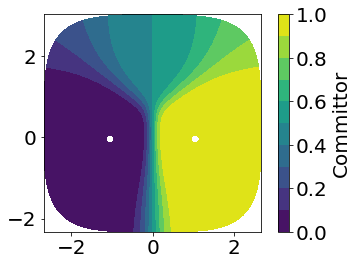

In [23]:
# find the mesh points lying on the Dirichlet boundary \partial A \cup \partial B
NAind,Aind = find_ABbdry_pts(pts,xa,ya,ra,h0) # find mesh points on \partial A
NBind,Bind = find_ABbdry_pts(pts,xb,yb,rb,h0) # find mesh points on \partial B
# find the committor
q = FEM_committor_solver(pts, tri, Aind, Bind, pot.V, beta)
# visualize the committor
plt.tricontourf(pts[:,0], pts[:,1], tri, q, np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))
plt.colorbar(label="Committor", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})
#plt.savefig('mueller_committor.pdf')
np.savetxt('ES_comm.txt', q)

In [24]:
from matplotlib.tri import Triangulation, TriFinder, LinearTriInterpolator
triangulation = Triangulation(pts[:,0], pts[:,1], tri)
interp = LinearTriInterpolator(triangulation, q, trifinder=triangulation.get_trifinder())
interp._interpolate_multikeys(x=-0.5, y=2, tri_index=None, return_keys=('z',))

[masked_array(data=0.4619288,
              mask=False,
        fill_value=1e+20)]

In [25]:
a  = interp._interpolate_multikeys(x=-0.5, y=2, tri_index=None, return_keys=('z',))[0]

In [26]:
np.savetxt('ES_comm.txt', q)

In [27]:
interp._interpolate_single_key(return_key=('z',), x=0, y=0, tri_index=None)

TypeError: can only concatenate str (not "tuple") to str

Npts =  27  Ntri =  39
Npts =  27  Ntri =  39
Z =  [2701173.2274873]


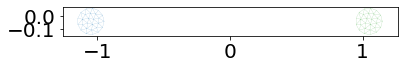

In [14]:
def dfuncA(p):
    return dcircle(p,xa,ya,ra)

def dfuncB(p):
    return dcircle(p,xb,yb,rb)
bbox = [xa-ra,xa+ra,ya-ra,ya+ra]
pts_Amesh,tri_Amesh = distmesh2D(dfuncA, huniform, h0, bbox, ptsA)
bbox = [xb-rb,xb+rb,yb-rb,yb+rb]
pts_Bmesh,tri_Bmesh = distmesh2D(dfuncB, huniform, h0, bbox, ptsB)

Npts_Amesh = np.size(pts_Amesh,axis=0)
Ntri_Amesh = np.size(tri_Amesh,axis=0)
print("Npts = ",Npts_Amesh," Ntri = ",Ntri_Amesh) 

Npts_Bmesh = np.size(pts_Bmesh,axis=0)
Ntri_Bmesh = np.size(tri_Bmesh,axis=0)
print("Npts = ",Npts_Bmesh," Ntri = ",Ntri_Bmesh) 
                         
Z = invariant_pdf(pts,tri, pts_Amesh, tri_Amesh, pts_Bmesh, tri_Bmesh, pot.V, beta)
print("Z = ",Z)

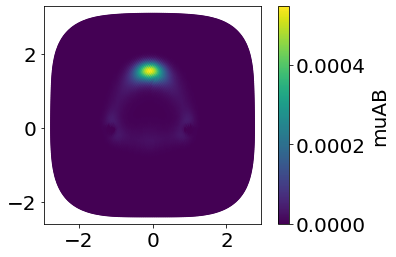

In [15]:
# probability density of reactive trajectories
mu = np.exp(-beta*pot.V(pts))/Z
muAB = mu*q*(1-q)
plt.scatter(pts[:,0], pts[:,1],c = muAB)
plt.colorbar(label="muAB", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})
#plt.savefig('mueller_muAB.pdf')

In [16]:
print(pts.shape)
print(q.shape)
print(muAB.shape)

(12489, 2)
(12489,)
(12489,)


In [17]:
indices = np.random.choice(a=np.arange(len(pts)), size=50, p=muAB/np.sum(muAB), replace=True)
points = pts[indices]

In [ ]:
plt.scatter(pts[:,0], pts[:,1],c = muAB)
plt.colorbar(label="muAB", orientation="vertical")
plt.scatter(points[:, 0], points[:, 1], color="orange", marker='.', s=0.5)
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})

In [ ]:
plt.hist(points[:, 0], 40)

In [ ]:
plt.hist(points[:, 1], 40)

In [ ]:
ref_committor_values = np.append(pts[indices], q[indices].reshape([len(pts[indices]), 1]), axis=1)

In [ ]:
ref_committor_values.shape

In [ ]:
np.savetxt('ref_committor_values_FEM.txt', ref_committor_values)